# Image Preprocessing

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import ipywidgets as widgets

from calibration import Calibration
from utils import display_images, embed_image
import preprocessing

In [2]:
# sample images
test_images = glob.glob('test_images/*.jpg')
project_images = glob.glob('test_images/video_samples/project*.jpg')
challange_images = glob.glob('test_images/video_samples/challange*.jpg')
harder_challange_images = glob.glob('test_images/video_samples/harder_challange*.jpg')

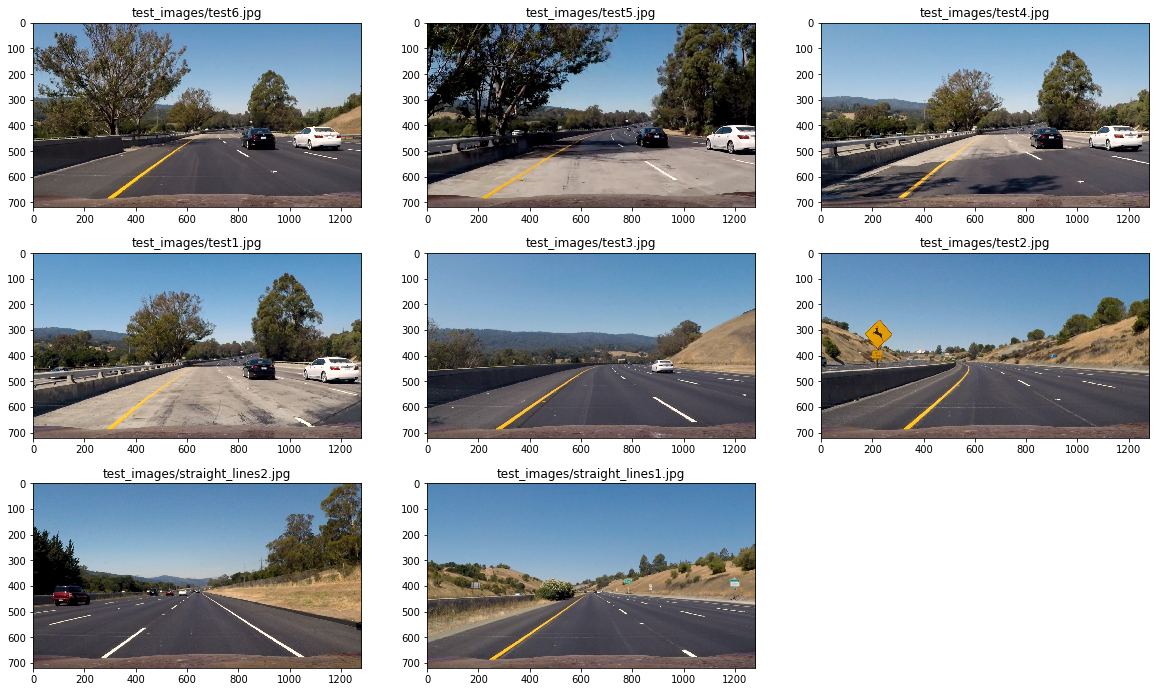

In [3]:
display_images([mpimg.imread(x) for x in test_images], [x for x in test_images], figsize=(20,12))

## Camera Calibration

In [4]:
cal = Calibration(nx=9, ny=6)
cal.compute_cal('camera_cal/calibration*.jpg')
print(cal)

Loaded camera config from file: calibration.pkl
Camera matrix: 
[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Dist coefficients: 
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]



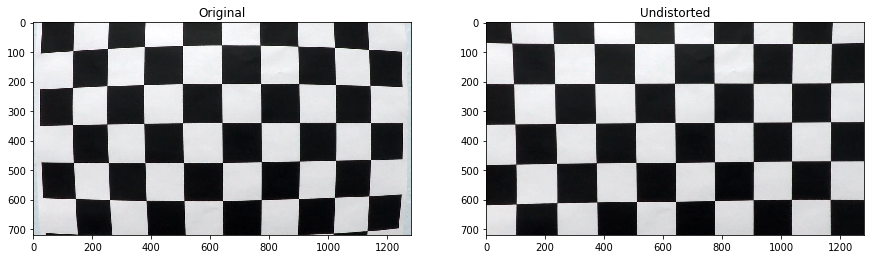

In [5]:
# undistort sample image
# note this image was not used for calibration because all corners could not be found
img = cv2.imread('camera_cal/calibration1.jpg')
# undistort image
dst = cal.undistort(img)
display_images([img, dst,], ['Original', 'Undistorted'], figsize=(23,10))
# display_images([img, dst,], ['Original', 'Undistorted'], figsize=(23,10), fname='calibration.jpg')

## Color Spaces

In [6]:
# test color spaces
def display_color_spaces(fname):
    img = mpimg.imread(fname)
    display_images([img], [fname], figsize=(15,5))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    display_images([img[:,:,0], img[:,:,1], img[:,:,2], hsv[:,:,0], hsv[:,:,1], hsv[:,:,2], hls[:,:,0], hls[:,:,1], 
                     hls[:,:,2], lab[:,:,0], lab[:,:,1], lab[:,:,2], yuv[:,:,0], yuv[:,:,1], yuv[:,:,2]], 
                    ['rgb - Red','rgb - Green','rgb - Blue', 'hsv - Hue','hsv - Sat','hsv - Value', 'hls - Hue', 
                     'hls - Lightness', 'hls - Sat', 'lab - Lightness', 'lab - A', 'lab - B', 'yuv - Luma (y)', 
                     'yuv - U', 'yuv - V'], cmap='gray', figsize=(15,20))

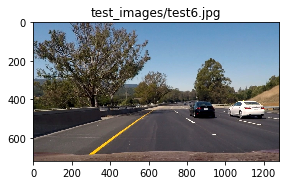

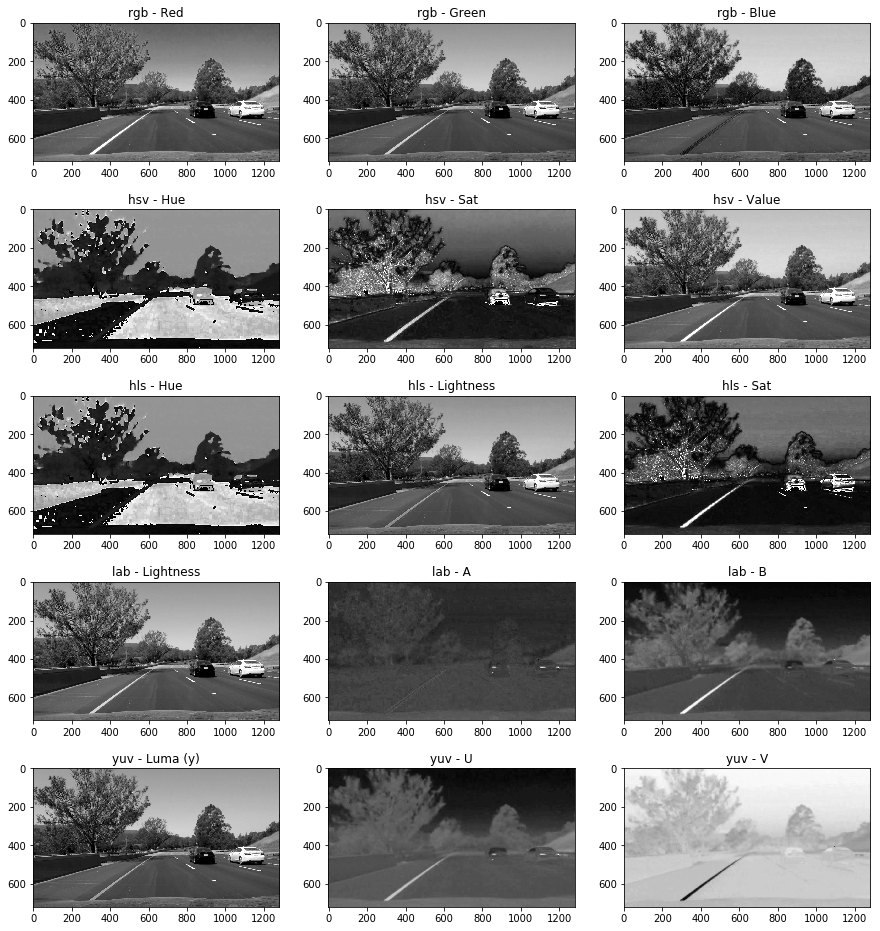

In [7]:
display_color_spaces(test_images[0])

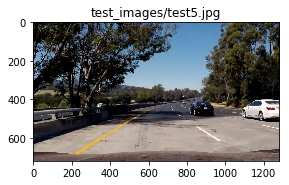

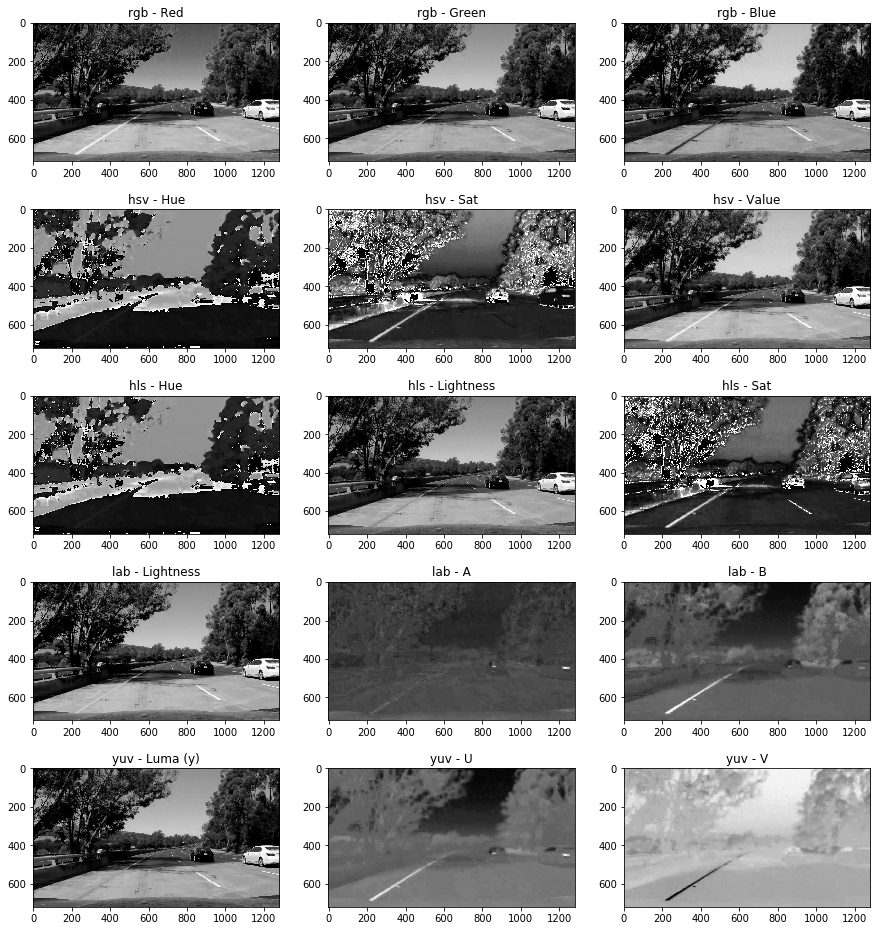

In [8]:
display_color_spaces(fname=test_images[1])

Thresholding should pass for both images above since they have different road colors

## Color Thresholding

Color thresholding to find lane lines. We tested RGB, HSV and HSL color spaces. Seperately extracting yellow and white lanes seemed to work the best. Overall HSL color space with yellow and white lanes thresholded seperately worked best.

In [9]:
def color_threshold_image3(img, thresholds):
    output = np.zeros([img.shape[0], img.shape[1]])   

    output[(((img[:,:,0] >= thresholds[0][0]) & (img[:,:,0] <= thresholds[0][1])) & 
            ((img[:,:,1] >= thresholds[1][0]) & (img[:,:,1] <= thresholds[1][1])) & 
            ((img[:,:,2] >= thresholds[2][0]) & (img[:,:,2] <= thresholds[2][1])))] = 1
    return output

def image_threshold_sliders(img, labels, n=3, initial_vals=[[0,255], [0,255], [0,255]]):
    values = initial_vals
    sliders = []
       
    def on_value_change(change):
        if change is not None:
            index = sliders.index(change.owner)
            values[index] = change.new
        mask = color_threshold_image3(img, values)
        # display image
        widgets.interact(lambda: plt.imshow(mask))
        
    for i in range(n):
        value = values[i]
        sliders.append(
            widgets.IntRangeSlider(
                value=value,
                min=0,
                max=255,
                step=1,
                description='{}:'.format(labels[i]),
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='d',
            )
        )
        display(sliders[i])
        sliders[i].observe(on_value_change, names='value')
    on_value_change(None)

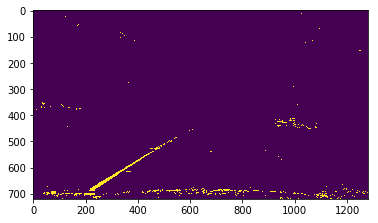

In [10]:
# rgb color playground
img = mpimg.imread(test_images[1])
image_threshold_sliders(img, ['Red', 'Green', 'Blue'], initial_vals=[[110,255],[90,255],[0,90]])

# gives us good white lanes [[180,255],[200,255],[0,255]]
# gives us okay results for yellow lanes [[110,255],[90,255],[0,90]]

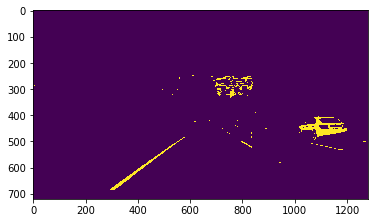

In [11]:
# HSV playground
img = cv2.cvtColor(mpimg.imread(test_images[0]), cv2.COLOR_RGB2HSV)
image_threshold_sliders(img, ['Hue', 'Sat', 'Val'], initial_vals=[[0,255],[0,255],[220,255]])

# [[0,255],[0,255],[220,255]] works well for both lanes

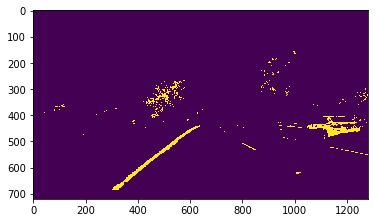

In [12]:
#HLS playground
img = cv2.cvtColor(mpimg.imread(test_images[2]), cv2.COLOR_RGB2HLS)
image_threshold_sliders(img, ['Hue', 'Lightness', 'Sat'], initial_vals= [(0,50),(50,255),(100,255)])

# [(0,255), (200,255), (0,255)] gives us white lanes
#  [(0,50),(50,255),(100,255)] gives us yellow lanes

In [13]:
def or_masks(mask1, mask2):
    mask_out = np.zeros_like(mask1)
    color_out = np.dstack((mask_out, mask1, mask2))
    mask_out[((mask1==1) | (mask2==1))] = 1
    return mask_out, color_out

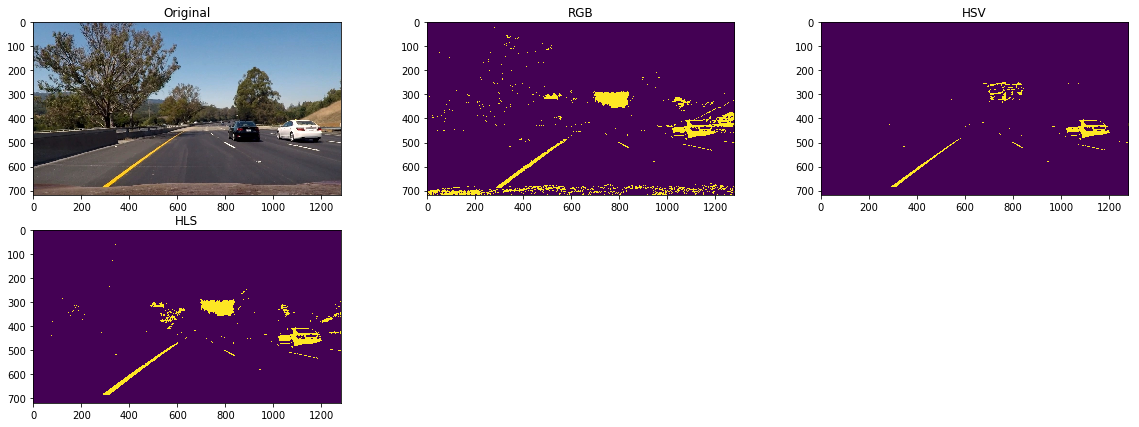

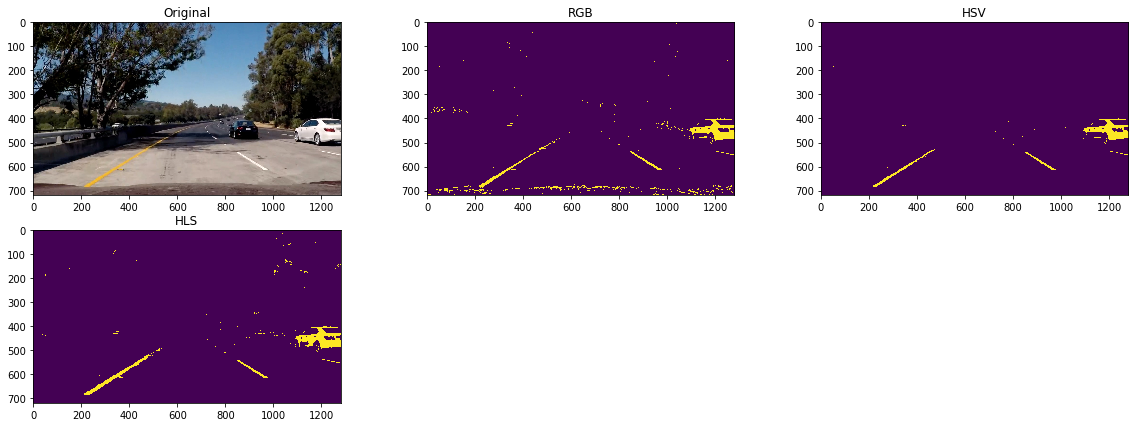

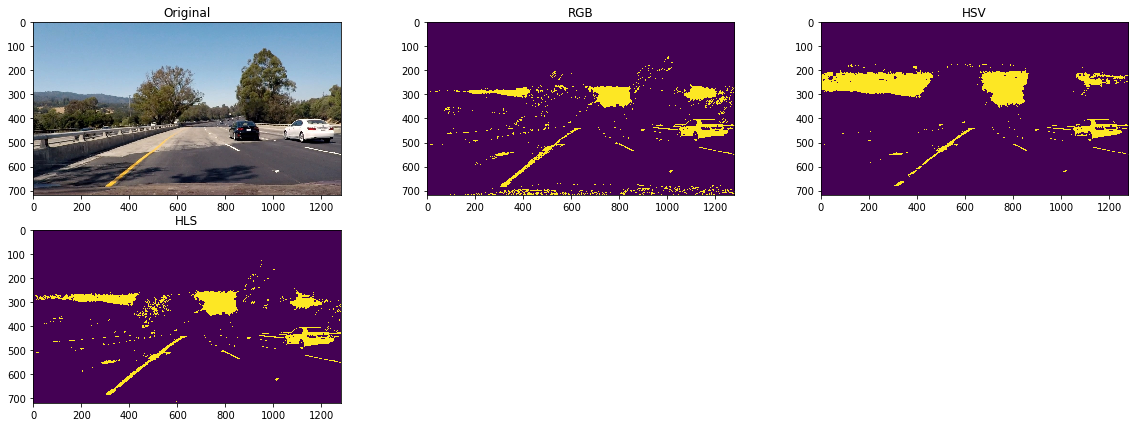

In [14]:
images = [mpimg.imread(x) for x in test_images[:3]]

for img in images:
    # rgb 
    rgb_mask, _ = or_masks(color_threshold_image3(img, [[180,255],[200,255],[0,255]]), 
                        color_threshold_image3(img, [[110,255],[90,255],[0,90]]))
    # hsv
    hsv_mask = color_threshold_image3(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), 
                                      [[0,255],[0,255],[220,255]])
    # hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_mask, _ = or_masks(color_threshold_image3(hls, [(0,255), (200,255), (0,255)]), 
                           color_threshold_image3(hls, [(0,50),(50,255),(100,255)]))
    display_images([img, rgb_mask, hsv_mask, hls_mask], ['Original', 'RGB', 'HSV', 'HLS'], figsize=(20,7))

## Gradient Thresholding

In [15]:
#helpers

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    '''
    takes derivate in one axis and thresholds on it
    '''
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative = None
    if orient == 'x':
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        derivative = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take abs value
    abs_derivative = np.absolute(derivative)
    # scale up to 8-bit
    scaled_derivative = np.int8(255*abs_derivative/np.max(abs_derivative))
    # create mask with threshold
    mask = np.zeros_like(scaled_derivative)
    mask[(scaled_derivative >= thresh[0]) & (scaled_derivative <= thresh[1])] = 1
    return mask

def abs_sobel_thresh_x(img, sobel_kernel, thresh):
    return abs_sobel_thresh(img, 'x', sobel_kernel, thresh)

def abs_sobel_thresh_y(img, sobel_kernel, thresh):
    return abs_sobel_thresh(img, 'y', sobel_kernel, thresh)

def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    '''
    takes derivate in x and y and thresholds on combined magnitude
    '''
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take magnitude value
    mag_derivative = np.sqrt(np.square(derivative_x) + np.square(derivative_y))
    # scale up to 8-bit
    scaled_derivative = np.int8(255*mag_derivative/np.max(mag_derivative))
    # create mask with threshold
    mask = np.zeros_like(scaled_derivative)
    mask[(scaled_derivative >= thresh[0]) & (scaled_derivative <= thresh[1])] = 1
    return mask

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    takes derivative in x and y and thresholds on direction of gradient
    '''
    # single channel
    assert len(img.shape) == 2
    # take derivative
    derivative_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    derivative_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take abs of x and y
    abs_x = np.absolute(derivative_x)
    abs_y = np.absolute(derivative_y)
    # find direction
    direction = np.arctan2(abs_y, abs_x)
    # create mask with threshold
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return mask

def gradient_threshold_sliders(img, grad_func, initial_vals=[3, [0,255]]):
    values = initial_vals
    
    def on_value_change(change):
        if change is not None:
            if change.owner == kernel_size:
                values[0] = change.new
            elif change.owner == threshold:
                values[1] = change.new
        mask = grad_func(img, values[0], values[1])
        # display image
        widgets.interact(lambda: plt.imshow(mask))
    
    # kernel size    
    kernel_size = widgets.IntSlider(
        value=values[0],
        min=3,
        max=30,
        step=2,
        description='Kernel Size:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    # threshold
    if grad_func == dir_thresh:
        threshold = widgets.FloatRangeSlider(
            value=values[1],
            min=0,
            max=np.pi/2,
            step=0.1,
            description='Threshold:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )
    else:
        threshold = widgets.IntRangeSlider(
            value=values[1],
            min=0,
            max=255,
            step=1,
            description='Threshold:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )
    
    kernel_size.observe(on_value_change, names='value')
    threshold.observe(on_value_change, names='value')
    display(kernel_size)
    display(threshold)
    
    on_value_change(None)

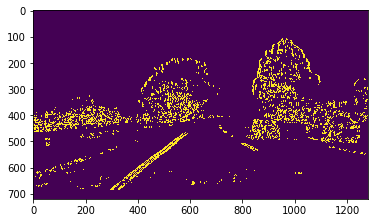

In [16]:
# sobel in x
gradient_img = cv2.cvtColor(mpimg.imread(test_images[2]), cv2.COLOR_RGB2HLS)[:,:,2]
gradient_threshold_sliders(gradient_img, abs_sobel_thresh_x, initial_vals=[15, [30,100]])

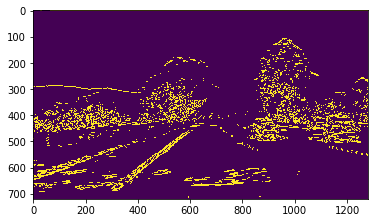

In [17]:
# sobel in y
gradient_img = cv2.cvtColor(mpimg.imread(test_images[2]), cv2.COLOR_RGB2HLS)[:,:,2]
gradient_threshold_sliders(gradient_img, abs_sobel_thresh_y, initial_vals=[9, [30,100]])

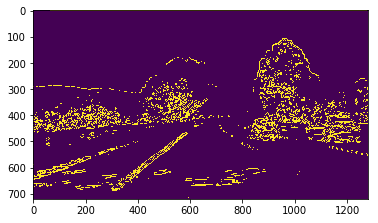

In [18]:
# gradient magnitude
gradient_img = cv2.cvtColor(mpimg.imread(test_images[2]), cv2.COLOR_RGB2HLS)[:,:,2]
gradient_threshold_sliders(gradient_img, mag_thresh, initial_vals=[9, [40,100]])

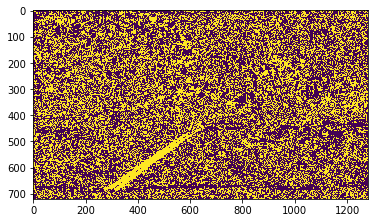

In [19]:
# gradient direction
gradient_img = cv2.cvtColor(mpimg.imread(test_images[0]), cv2.COLOR_RGB2HLS)[:,:,2]
gradient_threshold_sliders(gradient_img, dir_thresh, initial_vals=[15, [0.6, 1.3]])

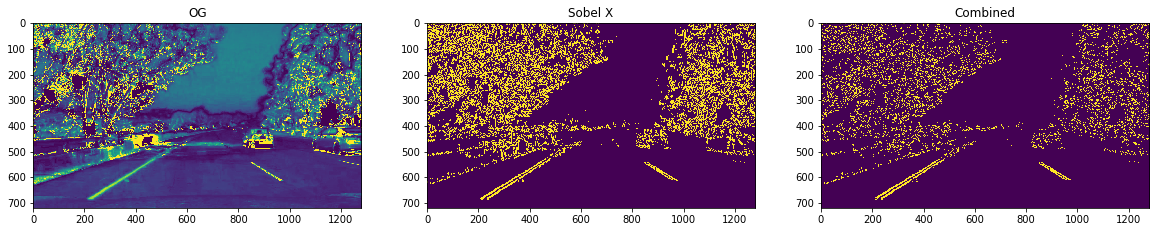

In [20]:
# sobel x + gradient direction
gradient_img = cv2.cvtColor(mpimg.imread(test_images[1]), cv2.COLOR_RGB2HLS)[:,:,2]
mask_x = abs_sobel_thresh_x(gradient_img, 15, (30,100))
mask_dir = dir_thresh(gradient_img, 15, (0.6, 1.30))

mask = np.zeros_like(mask_x)
mask[((mask_x == 1) & (mask_dir==1))] = 1
display_images([gradient_img, mask_x, mask], ['OG', 'Sobel X', 'Combined'], figsize=(20,10))

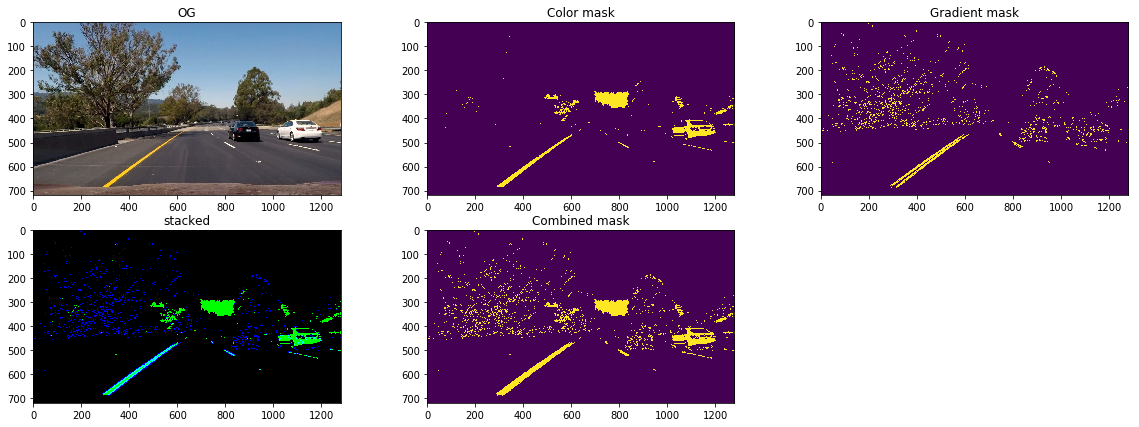

In [21]:
# color vs gradient comparison

# color mask
img = mpimg.imread(test_images[0])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hls_mask, _ = or_masks(color_threshold_image3(hls, [(0,255), (200,255), (0,255)]), 
                       color_threshold_image3(hls, [(0,50),(50,255),(100,255)]))
# gradient mask
gradient_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
mask_x = abs_sobel_thresh_x(gradient_img, 15, (30,100))
mask_dir = dir_thresh(gradient_img, 15, (0.6, 1.30))
mask_grad = np.zeros_like(mask_x)
mask_grad[((mask_x == 1) & (mask_dir==1))] = 1

stacked_img = np.dstack((np.zeros_like(mask_grad), hls_mask, mask_grad))

mask = np.zeros_like(mask_grad)
mask[((mask_grad==1) | (hls_mask==1))] = 1

display_images([img, hls_mask, mask_grad, stacked_img, mask], ['OG', 'Color mask', 'Gradient mask', 'stacked', 'Combined mask'], figsize=(20,7))

## Image wrapping and shape masking

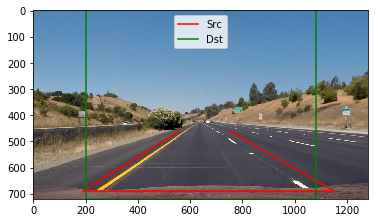

In [22]:
image_straight_lines = mpimg.imread(test_images[7])
roi_src = np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32')
roi_dst = np.array([[200, 0], [200,720], [1080,720], [1080, 0]], dtype='float32')
plt.plot(roi_src[:,0], roi_src[:,1], 'r-')
plt.plot(roi_dst[:,0], roi_dst[:,1], 'g-')
plt.legend(['Src', 'Dst'])
plt.imshow(image_straight_lines)

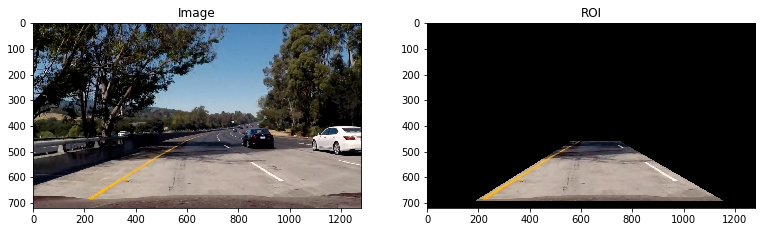

In [23]:
def roi(img, vertices):
    '''
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    '''
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread(test_images[1])
roi_mask = roi(img, roi_src)
display_images([img, roi_mask], ['Image', 'ROI'], figsize=(20,8))

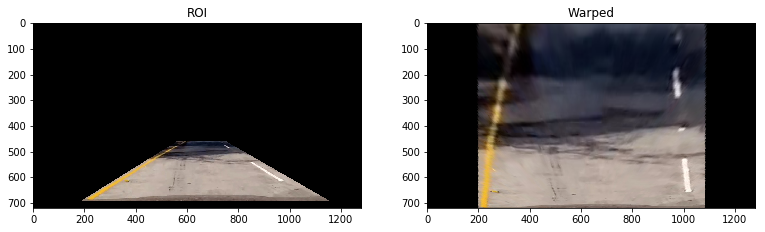

In [24]:
def get_prespective_transform(src, dst):
    '''
    Calculate prespective transform matrices
    '''
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    return M, M_inv

def warp_image(img, matrix):
    '''
    Warp image by applying prespective transform
    '''
    img_size = (img.shape[1], img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, matrix, img_size)

M, M_inv = get_prespective_transform(roi_src, roi_dst)
warped = warp_image(roi_mask, M)
display_images([roi_mask, warped], ['ROI', 'Warped'], figsize=(20,8))

## Image Pipeline

* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").

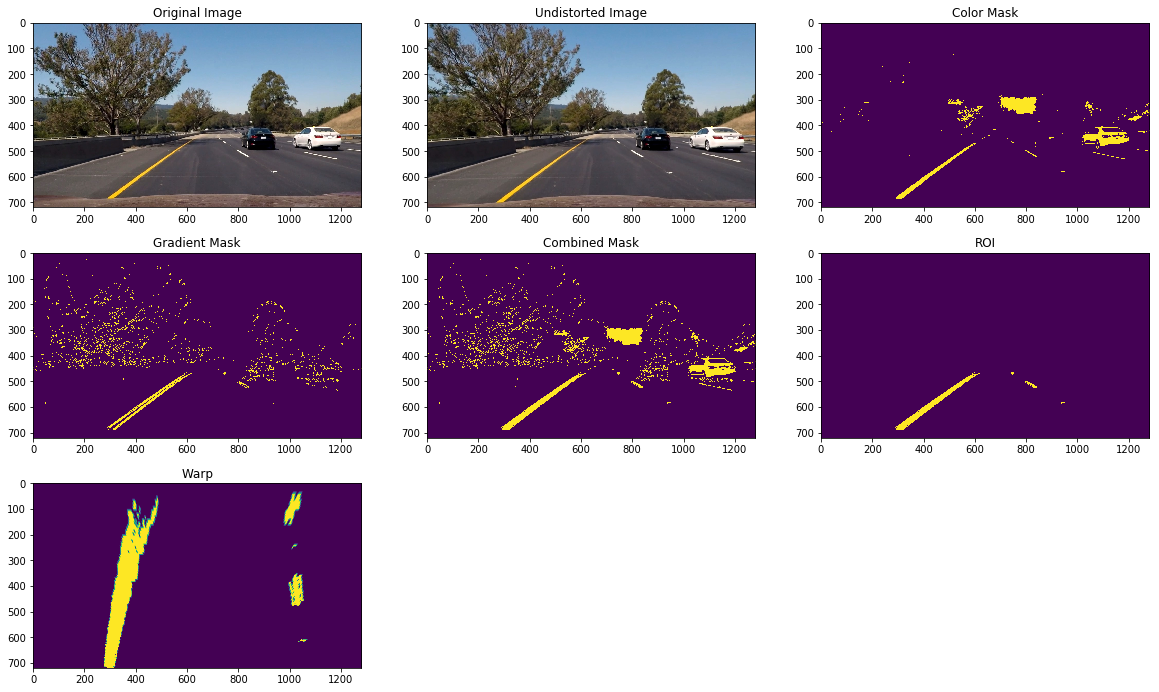

In [25]:
img = mpimg.imread(test_images[0])
# undistort
dst = cal.undistort(img)    
# color threshold 
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hls_mask = preprocessing.or_masks(preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[0]), 
                                  preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[1]))
# gradient threshold
red_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
gradient_mask = preprocessing.gradient_threshold(red_channel, 
                                                 kernel_size=preprocessing.GRADIENT_KERNEL_SIZE,
                                                 thresholds=preprocessing.GRADIENT_THRESHOLD)
# combine thresholds
mask = preprocessing.or_masks(hls_mask, gradient_mask)
# roi
roi = preprocessing.roi(mask, preprocessing.ROI_SRC)
# warp image
warped = preprocessing.warp_image(roi, M)

display_images([img, dst, hls_mask, gradient_mask, mask, roi, warped], 
               ['Original Image', 'Undistorted Image', 'Color Mask', 'Gradient Mask', 'Combined Mask', 'ROI', 'Warp'], 
              figsize=(20,12))

In [26]:
def process_img(img):
    # undistort
    dst = cal.undistort(img)    
    # color threshold 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_mask = preprocessing.or_masks(preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[0]), 
                                      preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[1]))
    # gradient threshold
    red_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    gradient_mask = preprocessing.gradient_threshold(red_channel, 
                                                     kernel_size=preprocessing.GRADIENT_KERNEL_SIZE,
                                                     thresholds=preprocessing.GRADIENT_THRESHOLD)
    # combine thresholds
    mask = preprocessing.or_masks(hls_mask, gradient_mask)
    # roi
    roi = preprocessing.roi(mask, preprocessing.ROI_SRC)
    # warp image
    warped = preprocessing.warp_image(roi, M)
    return warped

### Make video for testing

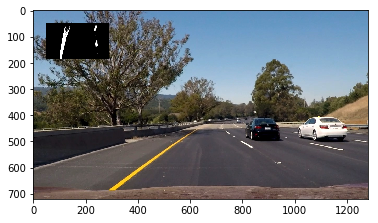

In [27]:
plt.imshow(embed_image(img, warped))

In [28]:
# run the thresholding on the video to check results
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def f(img):
    return embed_image(img, process_img(img))

clip = VideoFileClip("test_videos/project_video.mp4")
output = clip.fl_image(f)
output.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:49<00:00,  4.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [29]:
HTML("""
<video width="960" controls>
    <source src="{}"">
</video>
""".format('output.mp4'))